A Neural network approach to composite model

In [1]:
# utils
import warnings

# data processing and handling pkgs
import pandas as pd
import numpy as np
from astral import LocationInfo
from astral.sun import sun


# plotting packages
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go

# NN modelling packages
import keras

import seaborn as sns
import matplotlib.pyplot as plt

# custom methods
from custom_utils import *

# global settings
np.random.seed(27)
warnings.filterwarnings("ignore")

## Load data

In [2]:
data_path = "./../data/"
file_name = "data.csv"
data = pd.read_csv(data_path + file_name)
data = first_preprocess(data, data_path)
data.head()

,space_heating,hot_water,sockets,lighting,bld_engcons,car_chargers,weekend,bank_holiday,day_of_week,day_of_month,...,forecast_weathertype,forecast_windspeed,forecast_uvindex,forecast_precipitationprobability,forecast_visibility,week_of_year,sine_hour,cos_hour,sine_forecast_winddirection,cos_forecast_winddirection
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,3.425193,0.000000,0.049433,0.154873,3.629499,0.0,0,1,5,1,...,2.0,11.0,0.0,0.0,5,53,0.000000,1.000000,0.000000,1.00000
2021-01-01 01:00:00+00:00,4.012907,0.000000,0.047753,0.154846,4.215506,0.0,0,1,5,1,...,2.0,11.0,0.0,0.0,5,53,0.258819,0.965926,0.000000,1.00000
2021-01-01 02:00:00+00:00,5.342417,0.444782,0.051869,0.154997,5.994066,0.0,0,1,5,1,...,2.0,11.0,0.0,1.0,5,53,0.500000,0.866025,0.000000,1.00000
2021-01-01 03:00:00+00:00,5.756598,0.000000,0.043028,0.154626,5.954252,0.0,0,1,5,1,...,0.0,11.0,0.0,1.0,5,53,0.707107,0.707107,-0.382683,0.92388
2021-01-01 04:00:00+00:00,5.415492,0.000000,0.050306,0.154498,5.620296,0.0,0,1,5,1,...,0.0,11.0,0.0,1.0,5,53,0.866025,0.500000,-0.382683,0.92388


In [3]:
data.columns

Index(['space_heating', 'hot_water', 'sockets', 'lighting', 'bld_engcons',
       'car_chargers', 'weekend', 'bank_holiday', 'day_of_week',
       'day_of_month', 'month', 'year', 'forecast_temperature',
       'forecast_feelslike', 'forecast_weathertype', 'forecast_windspeed',
       'forecast_uvindex', 'forecast_precipitationprobability',
       'forecast_visibility', 'week_of_year', 'sine_hour', 'cos_hour',
       'sine_forecast_winddirection', 'cos_forecast_winddirection'],
      dtype='object')

In [4]:
exo_columns = ['forecast_temperature', 'forecast_feelslike', 'forecast_weathertype',
       'forecast_windspeed', 'forecast_uvindex',
       'forecast_precipitationprobability', 'forecast_visibility',
       'week_of_year', 'daylight_hours', 'is_daylight', 'sine_hour',
       'cos_hour', 'sine_month', 'cos_month', 'sine_day_of_week',
       'cos_day_of_week', 'sine_forecast_winddirection',
       'cos_forecast_winddirection', 'sine_sunrise_hour', 'cos_sunrise_hour',
       'sine_sunset_hour', 'cos_sunset_hour']
endo_columns = ['weekend', 'bank_holiday', 'day_of_month', 'year', "others"]
target_column = ["y"]
column_name = exo_columns + endo_columns  + target_column
train_date = "2023-01-01"
test_date = '2023-01-01'


class DataTransform:
    """
    An implementation to transform the data


    """
    def __init__(self):
        pass

    @staticmethod
    def get_scaled_data(raw_data, column_name):
        """
        """
        data_scaler, transformed_data = create_std_scaler(raw_data, column_name[:-1])
        target_scaler, transformed_target_data = create_std_scaler(raw_data, column_name[-1])
        
        transformed_data = pd.merge(transformed_data, transformed_target_data, left_index=True, right_index=True)
        return data_scaler, target_scaler, transformed_data

    def sh_transform(self, raw_data):
        """
        """
        column_name = "space_heating"
        raw_data = raw_data.rename(columns={"space_heating": "t-1"})
        raw_data["space_heating"] = raw_data["t-1"].shift(-1)
        raw_data = raw_data.dropna(axis=0)
        column_names = raw_data.columns.tolist()
        data_scaler, target_scaler, transformed_data = self.get_scaled_data(raw_data, column_names)
        return data_scaler, target_scaler, transformed_data

    def others_transform(self, raw_data): 
        """
        """
        column_names = ["hot_water", "sockets", "lighting"]
        raw_data["others"] = raw_data[column_names].sum(axis=1)
        raw_data = raw_data.rename(columns={"others": "t-1"})
        raw_data["others"] = raw_data["t-1"].shift(-1)
        raw_data = raw_data.drop(columns=column_names + ['space_heating', 'bld_engcons', 'car_chargers'])
        raw_data = raw_data.dropna(axis=0)
        column_names = raw_data.columns.tolist()
        data_scaler, target_scaler, transformed_data = self.get_scaled_data(raw_data, column_names)
        return data_scaler, target_scaler, transformed_data

    def bldg_transform(self, raw_data):
        """
        """
        raw_data = raw_data.rename(columns={"bld_engcons": "y"})
        raw_data = raw_data[["y"]]
        raw_data["y"] = raw_data["y"].shift(-1)
        raw_data = raw_data.dropna(axis=0)
        return raw_data

    def transform(self, raw_data, prepare_for):
        """
        Args:
            raw_data: pd.DataFrame: data to be preprocessed
            prepare_for: str: preprocess as per the model data form
    
        Returns:
            processed_data: dict: data frame consisting of the preprocessed data
    
        Raises:
            ValueError
        """
        if prepare_for == "space_heating":
            data_scaler, target_scaler, transformed_data = self.sh_transform(raw_data)
            self.space_heating = {"data_scaler": data_scaler, "target_scaler": target_scaler, "transformed_data": transformed_data}
        elif prepare_for == "hot_water":
            data_scaler, target_scaler, transformed_data = self.sh_transform(raw_data)
            self.space_heating = {"data_scaler": data_scaler, "target_scaler": target_scaler, "transformed_data": transformed_data}
        elif prepare_for == "others":
            data_scaler, target_scaler, transformed_data = self.others_transform(raw_data)
            self.others = {"data_scaler": data_scaler, "target_scaler": target_scaler, "transformed_data": transformed_data}
        elif prepare_for == "car_chargers":
            pass
        elif prepare_for == "building":
            transformed_data = self.bldg_transform(raw_data)

        # train validation - test split 
        preprocessed_data = {
            "train": transformed_data[transformed_data.index < train_date],
            "test": transformed_data[transformed_data.index >= test_date],
            # "validation": transformed_data[(transformed_data.index >= train_date) & (transformed_data.index < test_date)],
        }
        # check the data dimentions
        assert preprocessed_data["train"].shape[1] == preprocessed_data["test"].shape[1]
        # assert preprocessed_data["train"].shape[1] == preprocessed_data["validation"].shape[1]
        # assert preprocessed_data["test"].shape[1] == preprocessed_data["validation"].shape[1]
        return preprocessed_data
    
    
transform_pipeline = DataTransform()

# prepare the space heating data
space_heating_data = transform_pipeline.transform(data.copy(), "space_heating")

# prepare the others circuits data
others_data = transform_pipeline.transform(data.copy(), "others")

# prepare the building circuits data
building_data = transform_pipeline.transform(data.copy(), "building")

                              columns         mean    variance  scale_factor
0                                 t-1     0.921509    1.409238      1.187113
1                           hot_water     0.173542    0.141593      0.376289
2                             sockets     0.091485    0.031124      0.176420
3                            lighting     0.229048    0.032864      0.181284
4                         bld_engcons     1.415584    1.803861      1.343079
5                        car_chargers     1.054802    9.257305      3.042582
6                             weekend     0.286731    0.204516      0.452235
7                        bank_holiday     0.024658    0.024050      0.155082
8                         day_of_week     3.001941    4.008939      2.002233
9                        day_of_month    15.719967   77.368021      8.795909
10                              month     6.525819   11.886991      3.447752
11                               year  2021.999962    0.666654      0.816489

In [5]:
others_data["train"].shape, building_data["train"].shape, space_heating_data["train"].shape

((17520, 20), (17520, 1), (17520, 25))

In [6]:
others_data["test"].shape, building_data["test"].shape, space_heating_data["test"].shape

((8759, 20), (8759, 1), (8759, 25))

In [7]:
others_data["train"].isna().sum()

weekend                              0
bank_holiday                         0
day_of_week                          0
day_of_month                         0
month                                0
year                                 0
forecast_temperature                 0
forecast_feelslike                   0
forecast_weathertype                 0
forecast_windspeed                   0
forecast_uvindex                     0
forecast_precipitationprobability    0
forecast_visibility                  0
week_of_year                         0
sine_hour                            0
cos_hour                             0
sine_forecast_winddirection          0
cos_forecast_winddirection           0
t-1                                  0
others                               0
dtype: int64

In [8]:
from keras.layers import Dense, concatenate
from keras.models import Model
from keras.optimizers import Adam
import keras

In [9]:
def get_model():
    # A = space heating model
    # B = others model
    inputA = keras.Input(shape=(space_heating_data["train"].shape[1],))
    inputB = keras.Input(shape=(others_data["train"].shape[1],))
    
    # space heating model
    space_heating_model = Dense(4, activation="relu")(inputA)
    space_heating_model = Dense(2, activation="relu")(space_heating_model)
    space_heating_model = Model(inputs=inputA, outputs=space_heating_model)
    
    # others model
    others_model = Dense(4, activation="relu")(inputB)
    others_model = Dense(2, activation="relu")(others_model)
    others_model = Model(inputs=inputB, outputs=others_model)
    
    # combine the output of the models
    combined = concatenate([space_heating_model.output, others_model.output])
    
    # building model
    bldg_model = Dense(2, activation="relu")(combined)
    bldg_model = Dense(1, activation="linear")(bldg_model)
    
    model = Model(inputs=[space_heating_model.input, others_model.input], outputs=bldg_model)
    return model

model_mape = get_model()
model_mape.summary()
    

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 4)            104         ['input_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 4)            84          ['input_2[0][0]']                
                                                                                            

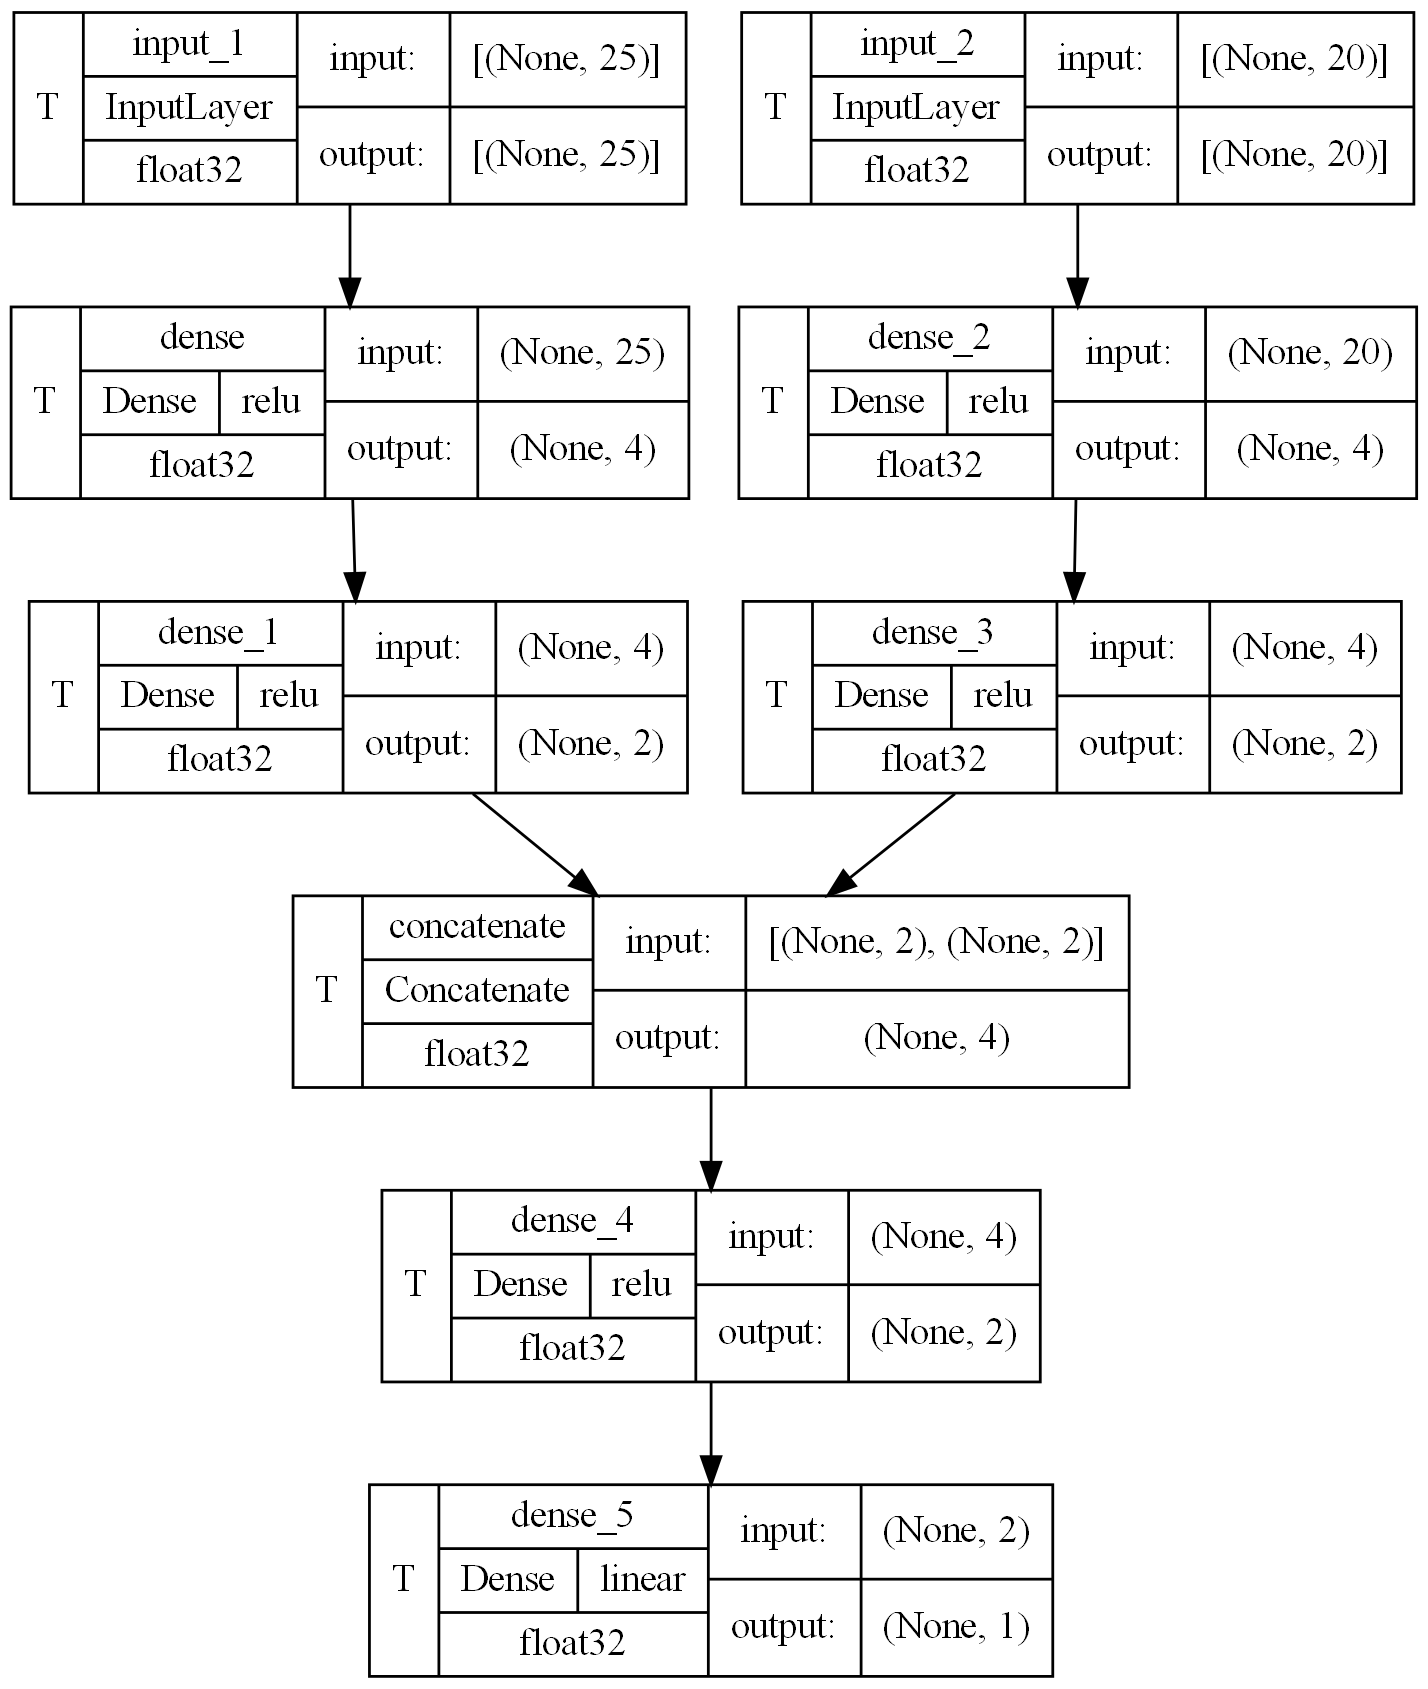

In [10]:
keras.utils.plot_model(
    model_mape,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True)

In [11]:
opt = Adam(lr=1e-3, decay=1e-3/round(np.sqrt(space_heating_data["train"].shape[0])))
model_mape.compile(loss="mean_absolute_percentage_error", optimizer=opt)

In [12]:
model_history = model_mape.fit(
    x=[space_heating_data["train"], others_data["train"]], 
    y=building_data["train"]["y"],
    epochs=1000,
    steps_per_epoch=100,
    validation_split=0.30
)

Epoch 1/1000
100/100 [==============================] - 1s 5ms/step - loss: 155.6427 - val_loss: 143.0464
Epoch 2/1000
100/100 [==============================] - 0s 4ms/step - loss: 78.1814 - val_loss: 59.1807
Epoch 3/1000
100/100 [==============================] - 0s 3ms/step - loss: 54.7316 - val_loss: 50.5472
Epoch 4/1000
100/100 [==============================] - 0s 4ms/step - loss: 52.9233 - val_loss: 47.7127
Epoch 5/1000
100/100 [==============================] - 0s 3ms/step - loss: 51.7329 - val_loss: 45.7114
Epoch 6/1000
100/100 [==============================] - 0s 4ms/step - loss: 49.8475 - val_loss: 43.2329
Epoch 7/1000
100/100 [==============================] - 0s 4ms/step - loss: 44.3345 - val_loss: 40.2274
Epoch 8/1000
100/100 [==============================] - 0s 4ms/step - loss: 36.3565 - val_loss: 37.6802
Epoch 9/1000
100/100 [==============================] - 0s 3ms/step - loss: 32.4422 - val_loss: 36.2749
Epoch 10/1000
100/100 [==============================] - 0s 4m

In [13]:
model_mape.evaluate([space_heating_data["test"], others_data["test"]], building_data["test"]["y"])

274/274 [==============================] - 0s 1ms/step - loss: 3.7861


3.7861294746398926

In [14]:
predictions = model_mape.predict([space_heating_data["test"], others_data["test"]])

274/274 [==============================] - 1s 2ms/step


In [15]:
predictions = pd.DataFrame({"predictions": predictions.reshape(-1)})
predictions.head()

,predictions
0,3.331609
1,1.964526
2,1.916023
3,2.231017
4,1.865026


In [16]:
cal_metrics(predictions["predictions"].to_numpy(), building_data["test"]["y"].to_numpy())

,MAE,MAPE,R2_Score,SMAPE,nRMSE,RMSE,MASE
0,0.04032,3.59,0.999047,3.69,0.004164,0.040919,-0.04


In [17]:
def plot_history(model_hist):
    plt.plot(model_hist["loss"])
    plt.plot(model_hist["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper left")
    plt.show()

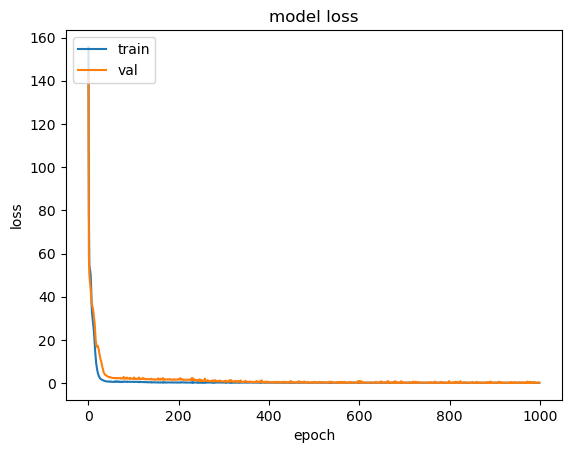

In [18]:
plot_history(model_history.history)

### Model testing with sMAPE

In [19]:
import tensorflow as tf

def calculate_smape_k(y_true, y_pred):
    epsilon = 0.1
    summ = tf.maximum(tf.abs(y_true) + tf.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = tf.abs(y_pred - y_true) / summ * 2.0
    return smape

In [20]:
model_smape = get_model()
opt2 = Adam(lr=1e-3, decay=1e-3/round(np.sqrt(space_heating_data["train"].shape[0])))
model_smape.compile(loss=calculate_smape_k, optimizer=opt2)

In [21]:
model_history_smape = model_smape.fit(
    x=[space_heating_data["train"], others_data["train"]], 
    y=building_data["train"]["y"],
    epochs=1000,
    steps_per_epoch=100,
    validation_split=0.30
)

Epoch 1/1000
100/100 [==============================] - 1s 4ms/step - loss: 1.5699 - val_loss: 1.2555
Epoch 2/1000
100/100 [==============================] - 0s 4ms/step - loss: 1.1061 - val_loss: 0.8455
Epoch 3/1000
100/100 [==============================] - 0s 4ms/step - loss: 0.8412 - val_loss: 0.6580
Epoch 4/1000
100/100 [==============================] - 0s 5ms/step - loss: 0.7572 - val_loss: 0.6307
Epoch 5/1000
100/100 [==============================] - 0s 4ms/step - loss: 0.7349 - val_loss: 0.6190
Epoch 6/1000
100/100 [==============================] - 0s 4ms/step - loss: 0.7205 - val_loss: 0.6119
Epoch 7/1000
100/100 [==============================] - 0s 4ms/step - loss: 0.7107 - val_loss: 0.6082
Epoch 8/1000
100/100 [==============================] - 0s 4ms/step - loss: 0.7036 - val_loss: 0.6054
Epoch 9/1000
100/100 [==============================] - 0s 4ms/step - loss: 0.6984 - val_loss: 0.6031
Epoch 10/1000
100/100 [==============================] - 0s 4ms/step - loss: 0.694

In [22]:
model_smape.evaluate([space_heating_data["test"], others_data["test"]], building_data["test"]["y"])

274/274 [==============================] - 0s 2ms/step - loss: 0.1569


0.15693800151348114

In [23]:
predictions = model_smape.predict([space_heating_data["test"], others_data["test"]])
predictions = pd.DataFrame({"predictions": predictions.reshape(-1)})
cal_metrics(predictions["predictions"].to_numpy(), building_data["test"]["y"].to_numpy())

274/274 [==============================] - 0s 2ms/step


,MAE,MAPE,R2_Score,SMAPE,nRMSE,RMSE,MASE
0,0.220127,14.55,0.817568,16.49,0.10361,0.439421,-0.22


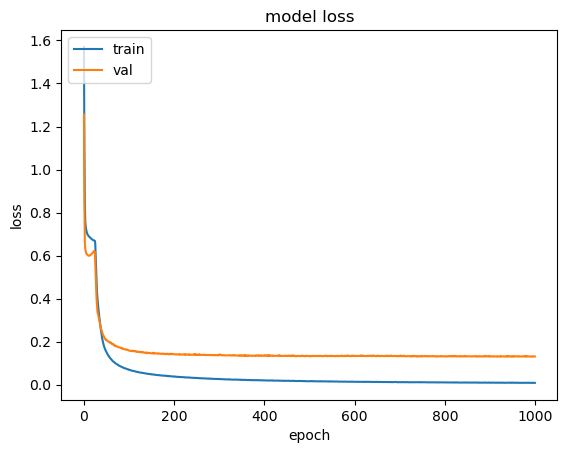

In [24]:
plot_history(model_history_smape.history)

### XAI

In [25]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [26]:
space_heating_data["test"].columns

Index(['t-1', 'hot_water', 'sockets', 'lighting', 'bld_engcons',
       'car_chargers', 'weekend', 'bank_holiday', 'day_of_week',
       'day_of_month', 'month', 'year', 'forecast_temperature',
       'forecast_feelslike', 'forecast_weathertype', 'forecast_windspeed',
       'forecast_uvindex', 'forecast_precipitationprobability',
       'forecast_visibility', 'week_of_year', 'sine_hour', 'cos_hour',
       'sine_forecast_winddirection', 'cos_forecast_winddirection',
       'space_heating'],
      dtype='object')

In [27]:
X100 = [space_heating_data["test"].iloc[:100, :].to_numpy(), 
        others_data["test"].iloc[:100, :].to_numpy()]

def predict_fxn(x):
    x = [x[0][0], x[1][0]]
    return model_smape.predict(x).flatten()

In [28]:
explainer = shap.DeepExplainer(model_smape, X100)

In [29]:
shap_values = explainer.shap_values(X100)

In [30]:
sample_ind = 45

In [31]:
shap_values[0].shape

(100, 25, 1)

In [32]:
space_heating_data["test"].columns, others_data["test"].columns

(Index(['t-1', 'hot_water', 'sockets', 'lighting', 'bld_engcons',
        'car_chargers', 'weekend', 'bank_holiday', 'day_of_week',
        'day_of_month', 'month', 'year', 'forecast_temperature',
        'forecast_feelslike', 'forecast_weathertype', 'forecast_windspeed',
        'forecast_uvindex', 'forecast_precipitationprobability',
        'forecast_visibility', 'week_of_year', 'sine_hour', 'cos_hour',
        'sine_forecast_winddirection', 'cos_forecast_winddirection',
        'space_heating'],
       dtype='object'),
 Index(['weekend', 'bank_holiday', 'day_of_week', 'day_of_month', 'month',
        'year', 'forecast_temperature', 'forecast_feelslike',
        'forecast_weathertype', 'forecast_windspeed', 'forecast_uvindex',
        'forecast_precipitationprobability', 'forecast_visibility',
        'week_of_year', 'sine_hour', 'cos_hour', 'sine_forecast_winddirection',
        'cos_forecast_winddirection', 't-1', 'others'],
       dtype='object'))

In [33]:
# # Example data (replace with your actual arrays)
array1 = shap_values[0]
array2 = shap_values[1]

# Calculate the differences between array2 and array1
differences = array2 - array1

# Create a DataFrame for Seaborn
df = pd.DataFrame(differences.reshape(-1, 25), columns=space_heating_data[])

# Plot the waterfall chart
plt.figure(figsize=(10, 6))
sns.barplot(data=df, ci=None, palette="coolwarm", orient="h")
plt.xlabel("Difference")
plt.ylabel("Features")
plt.title("Waterfall Plot: shap values for ")
plt.show()